--- Loading Files ---
--- Purchase Matrix Analysis ---
Dim: 3, Count: 10, Rank: 3
Candies (#): ₹1.00
Mangoes (Kg): ₹55.00
Milk Packets (#): ₹18.00
--- Classification Accuracy ---
Accuracy: 66.67%
--- Stock Price Stats ---
mean: 1560.6635
variance: 58732.3654
mean_wed: 1550.7060
mean_april: 1698.9526
prob_loss: 0.4980
prob_wed_gain: 0.0843
cond_prob_gain_wed: 0.4200


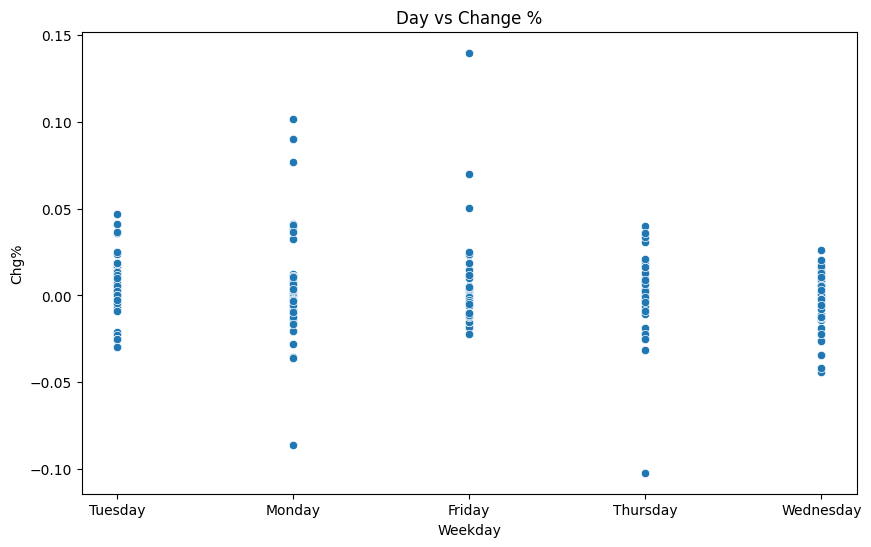

--- Thyroid Data Preprocessing ---
        age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
0  0.000824  sex           0.0                 0.0                        0.0   
1  0.000427    F           0.0                 0.0                        0.0   
2  0.000427    F           0.0                 0.0                        0.0   
3  0.000610    F           0.0                 0.0                        0.0   
4  0.000534    F           0.0                 0.0                        0.0   

   sick  pregnant  thyroid surgery  I131 treatment  query hypothyroid  ...  \
0   0.0       0.0              0.0             0.0                0.0  ...   
1   0.0       0.0              0.0             0.0                1.0  ...   
2   0.0       0.0              0.0             0.0                0.0  ...   
3   0.0       0.0              0.0             0.0                0.0  ...   
4   0.0       0.0              0.0             0.0                0.0  ...   

         

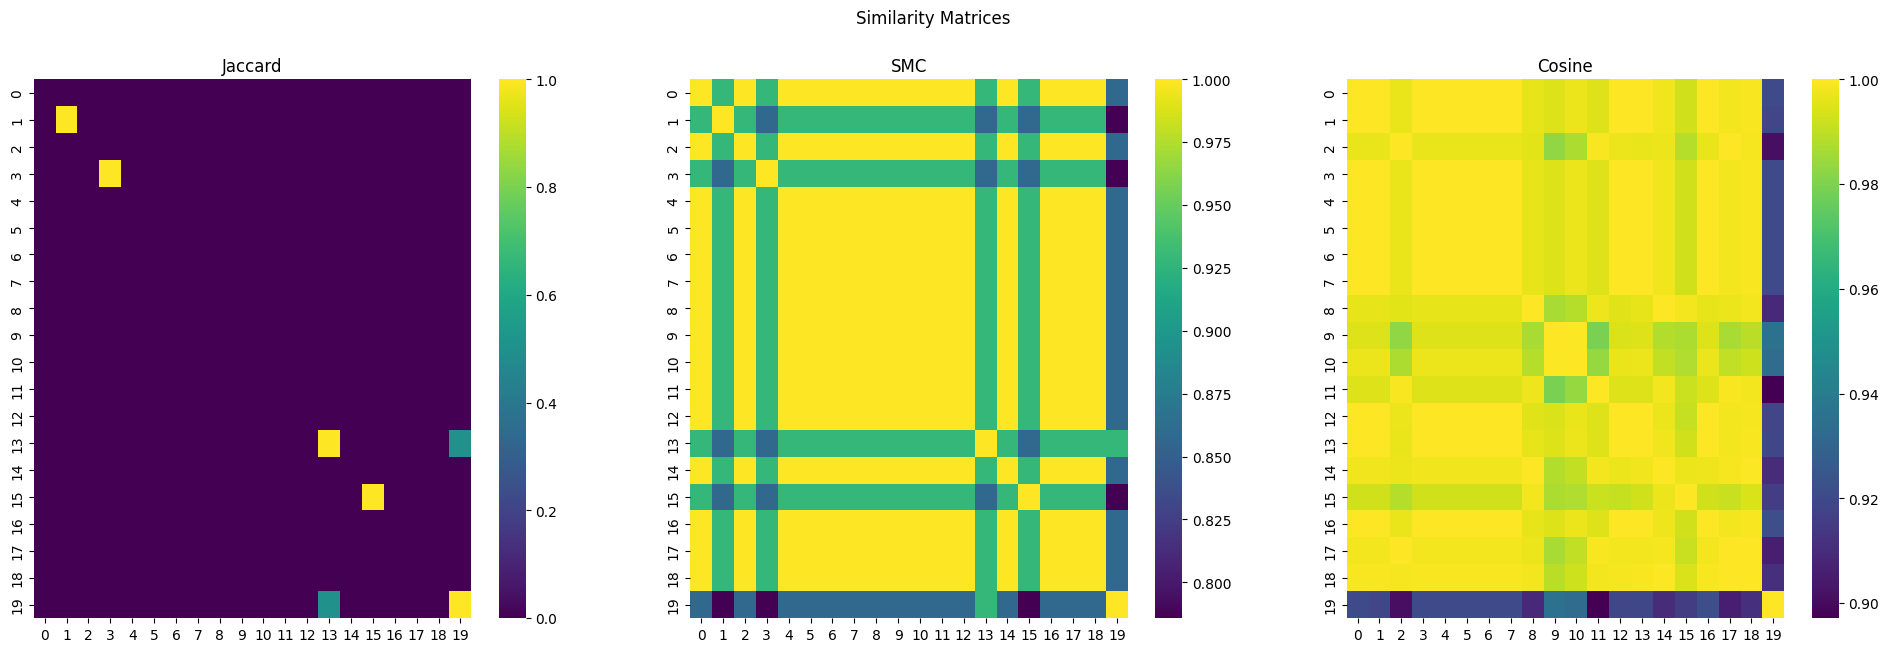

In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(path, has_hdr=True):
    try:
        return pd.read_csv(path) if has_hdr else pd.read_csv(path, header=None)
    except FileNotFoundError:
        return None

def analyze_matrix_purchase(data):
    numeric_part = data.columns[1:]
    for col in numeric_part:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)

    matrix_A = data.iloc[:, 1:-1].values
    vector_C = data.iloc[:, -1].values

    dim = matrix_A.shape[1]
    rows = matrix_A.shape[0]
    rank = np.linalg.matrix_rank(matrix_A)

    pinv_A = np.linalg.pinv(matrix_A)
    prices = np.dot(pinv_A, vector_C)

    return {
        "dimension": dim,
        "count": rows,
        "rank": rank,
        "costs": prices,
        "items": data.columns[1:-1]
    }

def classify_by_category(data):
    data['Group'] = np.where(data.iloc[:, -1] > 200, 'RICH', 'POOR')
    features = data.iloc[:, 1:-2]
    labels = data['Group']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    return accuracy_score(y_test, predictions)

def analyze_stocks(data):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['Price'] = pd.to_numeric(data['Price'].astype(str).str.replace(',', ''), errors='coerce')
    data['Chg%'] = pd.to_numeric(data['Chg%'].astype(str).str.replace('%', ''), errors='coerce') / 100.0
    data.dropna(subset=['Price', 'Chg%', 'Date'], inplace=True)

    mean_p = statistics.mean(data['Price'])
    var_p = statistics.variance(data['Price'])

    data['Weekday'] = data['Date'].dt.day_name()
    wed_prices = data[data['Weekday'] == 'Wednesday']['Price']
    mean_wed = statistics.mean(wed_prices) if not wed_prices.empty else 0

    april_data = data[data['Date'].dt.month == 4]['Price']
    mean_april = statistics.mean(april_data) if not april_data.empty else 0

    total = len(data)
    losses = len(data[data['Chg%'] < 0])
    wed_data = data[data['Weekday'] == 'Wednesday']
    wed_gains = len(wed_data[wed_data['Chg%'] > 0])

    prob_loss = losses / total if total > 0 else 0
    prob_gain_wed = wed_gains / total if total > 0 else 0
    prob_gain_given_wed = wed_gains / len(wed_data) if not wed_data.empty else 0

    return {
        "mean": mean_p,
        "variance": var_p,
        "mean_wed": mean_wed,
        "mean_april": mean_april,
        "prob_loss": prob_loss,
        "prob_wed_gain": prob_gain_wed,
        "cond_prob_gain_wed": prob_gain_given_wed,
        "plot_data": data
    }

def clean_thyroid_data(data):
    columns = [
        'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
        'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
        'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych',
        'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured',
        'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'Class'
    ]
    data.columns = ['ID'] + columns
    data.drop('ID', axis=1, inplace=True)
    data.replace('?', np.nan, inplace=True)

    bin_fields = [
        'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
        'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid',
        'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych'
    ]
    num_fields = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

    for col in num_fields:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    for col in bin_fields:
        data[col] = data[col].map({'f': 0, 't': 1})

    data.drop('TBG', axis=1, inplace=True)
    num_fields.remove('TBG')

    for col in data.columns:
        if col in num_fields:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

    scaler = MinMaxScaler()
    data[num_fields] = scaler.fit_transform(data[num_fields])

    return data, bin_fields, num_fields

def compute_similarities(data, bin_fields, num_fields):
    v1_bin = data[bin_fields].iloc[0]
    v2_bin = data[bin_fields].iloc[1]

    f11 = np.sum((v1_bin == 1) & (v2_bin == 1))
    f00 = np.sum((v1_bin == 0) & (v2_bin == 0))
    f10 = np.sum((v1_bin == 1) & (v2_bin == 0))
    f01 = np.sum((v1_bin == 0) & (v2_bin == 1))

    jc = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) else 0
    smc = (f11 + f00) / len(bin_fields)

    v1_num = data[num_fields].iloc[0]
    v2_num = data[num_fields].iloc[1]
    cosine = np.dot(v1_num, v2_num) / (np.linalg.norm(v1_num) * np.linalg.norm(v2_num))

    return {"jc": jc, "smc": smc, "cosine": cosine}

def plot_similarity_maps(data, bin_fields, num_fields):
    n = 20
    mat_jc = np.zeros((n, n))
    mat_smc = np.zeros((n, n))
    mat_cos = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            vb_i = data[bin_fields].iloc[i]
            vb_j = data[bin_fields].iloc[j]
            f11 = np.sum((vb_i == 1) & (vb_j == 1))
            f00 = np.sum((vb_i == 0) & (vb_j == 0))
            f10 = np.sum((vb_i == 1) & (vb_j == 0))
            f01 = np.sum((vb_i == 0) & (vb_j == 1))

            mat_jc[i, j] = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) else 0
            mat_smc[i, j] = (f11 + f00) / len(bin_fields)

            vn_i = data[num_fields].iloc[i]
            vn_j = data[num_fields].iloc[j]
            mat_cos[i, j] = np.dot(vn_i, vn_j) / (np.linalg.norm(vn_i) * np.linalg.norm(vn_j))

    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    sns.heatmap(mat_jc, ax=axs[0], cmap='viridis').set_title("Jaccard")
    sns.heatmap(mat_smc, ax=axs[1], cmap='viridis').set_title("SMC")
    sns.heatmap(mat_cos, ax=axs[2], cmap='viridis').set_title("Cosine")
    plt.suptitle("Similarity Matrices")
    plt.show()


# === Main Execution ===
if __name__ == "__main__":
    file_pur = 'purchase data.csv'
    file_stk = 'IRCTC stock price.csv'
    file_thy = 'thyroid0387_UCl.csv'

    print("--- Loading Files ---")
    data_pur = load_data(file_pur)
    data_stk = load_data(file_stk)
    data_thy = load_data(file_thy, has_hdr=False)

    if data_pur is not None:
        print("--- Purchase Matrix Analysis ---")
        res_pur = analyze_matrix_purchase(data_pur.copy())
        print(f"Dim: {res_pur['dimension']}, Count: {res_pur['count']}, Rank: {res_pur['rank']}")
        for item, val in zip(res_pur['items'], res_pur['costs']):
            print(f"{item}: ₹{val:.2f}")

        print("--- Classification Accuracy ---")
        acc = classify_by_category(data_pur.copy())
        print(f"Accuracy: {acc:.2%}")

    if data_stk is not None:
        print("--- Stock Price Stats ---")
        res_stk = analyze_stocks(data_stk.copy())
        for k, v in res_stk.items():
            if isinstance(v, float):
                print(f"{k}: {v:.4f}")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=res_stk['plot_data'], x='Weekday', y='Chg%')
        plt.title('Day vs Change %')
        plt.show()

    if data_thy is not None:
        print("--- Thyroid Data Preprocessing ---")
        thy_cleaned, bin_fields, num_fields = clean_thyroid_data(data_thy.copy())
        print(thy_cleaned.head())

        print("--- Similarity Metrics ---")
        res_sim = compute_similarities(thy_cleaned, bin_fields, num_fields)
        for k, v in res_sim.items():
            print(f"{k}: {v:.4f}")

        print("--- Similarity Heatmaps ---")
        plot_similarity_maps(thy_cleaned, bin_fields, num_fields)
